In [1]:
import os
import numpy as np
import tensorflow as tf
import skimage as sk
import matplotlib.pyplot as plt
from tqdm import tqdm

import models

PATH = '../data/landmarks/'

IMAGE_SIZE = (128,128,3)

# Limite size of input for testing
TEST_LIMIT = 1000

SPLIT = 0.8
BATCH_SIZE = 32
EPOCHS = 20
STEPS_PER_EPOCH = 40

## Dataset pre-processing

In [2]:
# Retrieve the raw images
resized_path = PATH + 'resized/'
filenames = os.listdir(resized_path)

## Sort the filenames in the proper order
filename_int = np.sort([int(s[:-4]) for s in filenames])

filenames = np.array([resized_path + str(i) + '.jpg' for i in filename_int])

# Retrieve the masks
masks_path = PATH + 'resized_masks/'
f_masks = os.listdir(masks_path)

## Sort the filenames in the proper order
f_masks_int = np.sort([int(s[:-4]) for s in f_masks])

f_masks = np.array([resized_path + str(i) + '.jpg' for i in f_masks_int])

# Retrieve the landmarks
labels = np.load(PATH + 'resized_labels.npy')

# Reshape the outputs
print(labels.shape)
print(f_masks.shape)
print(filenames.shape)
assert len(f_masks)==len(labels)
assert len(filenames)==len(labels)

if TEST_LIMIT>len(labels):
    TEST_LIMIT = len(labels)


w,h,c = IMAGE_SIZE
images = np.empty((0,w,h,c))

masks = np.empty((0,w,h,1))

print("Loading images...")
labels = labels[:TEST_LIMIT]
labels = np.reshape(labels,(TEST_LIMIT,14))
labels = labels[:,:10]

for i in tqdm(range(TEST_LIMIT)):
    image = sk.io.imread(filenames[i])
    image_resized = sk.transform.resize(image, IMAGE_SIZE)
    images = np.vstack((images,np.expand_dims(image_resized,0)))

    mask = sk.io.imread(f_masks[i])

    mask_resized = sk.transform.resize(mask, (w,h,1))
    masks = np.vstack((masks,np.expand_dims(mask_resized,0)))



train_split = int(SPLIT*len(labels))

images_train = images[:train_split]
images_valid = images[train_split:]

masks_train = masks[:train_split]
masks_valid = masks[train_split:]

labels_train = labels[:train_split]
labels_valid = labels[train_split:]

(658, 7, 2)
(658,)
(658,)
Loading images...


  0%|                                                                                          | 0/658 [00:00<?, ?it/s]c:\users\guillaume\anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\guillaume\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|████████████████████████████████████████████████████████████████████████████████| 658/658 [02:01<00:00,  5.41it/s]


## First try: model definition

In [4]:
def TriNet(ratio=4, input_shape=(128,128,3)):
    """
    Arguments:
     -ratio: ratio of channel reduction in SE module
     -imput_shape: input image shape
    """
    
    def CBA_layer(x, filters, size=3, depth=2):
        
        for _ in range(depth):
            x = tf.keras.layers.Conv2D(filters, (size, size), padding='same') (x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Activation('relu')(x)
            
        return x
    
    def Res_layer(x, num_split, filters):
        '''
        ResNet-like layer
        '''
        
        # Spliting the branches and changing the size of the convolution
        splitted_branches = list()
        
        for i in range(num_split):
            if i+1 < 6:
                size = i+1 
            else:
                size = 3
            branch = CBA_layer(x, filters, size)
            splitted_branches.append(branch)
        
        x = tf.keras.layers.concatenate(splitted_branches)
        
        x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same') (x)
        x = tf.keras.layers.BatchNormalization()(x)
        
        return x
    
    def SE_layer(x):
        '''
        SENet-like layer
        '''
        out_dim = int(np.shape(x)[-1])
        squeeze = tf.keras.layers.GlobalAveragePooling2D()(x)
        
        excitation = tf.keras.layers.Dense(units=out_dim // ratio)(squeeze)
        excitation = tf.keras.layers.Activation('relu')(excitation)
        excitation = tf.keras.layers.Dense(units=out_dim)(excitation)
        excitation = tf.keras.layers.Activation('sigmoid')(excitation)
        excitation = tf.keras.layers.Reshape((1,1,out_dim))(excitation)
        
        scale = tf.keras.layers.multiply([x,excitation])
        
        return scale
    
    def RSE_layer(x, num_split, filters):
        r = Res_layer(x, num_split, filters)
        s = SE_layer(r)
        c = tf.keras.layers.concatenate([x,s])
        return tf.keras.layers.Activation('relu')(c)
    

    inputs = tf.keras.Input(input_shape)

    s = tf.keras.layers.Lambda(lambda x: x / 255) (inputs)
    
    #Down 1
    r1 = RSE_layer(s, 2, 8)
    x = tf.keras.layers.MaxPooling2D((2, 2)) (r1)
    
    #Down 2
    r2 = RSE_layer(x, 4, 16)
    x = tf.keras.layers.MaxPooling2D((2, 2)) (r2)
    
    #Down 3
    r3 = RSE_layer(x, 4, 32)
    x = tf.keras.layers.MaxPooling2D((2, 2)) (r3)
    
    #Down 4
    r4 = RSE_layer(x, 6, 64)
    x = tf.keras.layers.MaxPooling2D((2, 2)) (r4)
    
    #Down 5
    r5 = RSE_layer(x, 6, 128)
    x = tf.keras.layers.MaxPooling2D((2, 2)) (r5)
    
    #Middle
    x = RSE_layer(x, 4, 256)

    # First branch: landmarks detection
    y = CBA_layer(x, 512)
    y = tf.keras.layers.GlobalAveragePooling2D()(y)
    y = tf.keras.layers.Flatten()(y)
    y = tf.keras.layers.Dense(10)(y)
    landmarks_output = tf.keras.layers.Lambda(lambda x: x * 255, name='landmarks_output')(y)
    
    # Second branch: mask generation
    #Up 1
    x = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (x)
    x = tf.keras.layers.concatenate([x,r5])
    x = RSE_layer(x, 6, 128)
    
    #Up 2
    x = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (x)
    x = tf.keras.layers.concatenate([x,r4])
    x = RSE_layer(x, 6, 64)
    
    #Up 3
    x = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (x)
    x = tf.keras.layers.concatenate([x,r3])
    x = RSE_layer(x, 4, 32)
    
    #Up 4
    x = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (x)
    x = tf.keras.layers.concatenate([x,r2])
    x = RSE_layer(x, 4, 16)
    
    #Up 5
    x = tf.keras.layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (x)
    x = tf.keras.layers.concatenate([x,r1])
    x = RSE_layer(x, 2, 8)
    
    mask_output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', name='mask_output') (x)
    
    return tf.keras.Model(inputs, [landmarks_output, mask_output])

In [12]:
def weighted_mse(y_true,y_pred):
    return tf.divide(tf.keras.losses.mse(y_true,y_pred), tf.constant(1000.0))
def zero_loss(y_true,y_pred):
    return tf.constant(0.0)

In [14]:
# layers = [10, 16, 32, 64, 128]
# model = models.MultiTaskResNet(layers, 14, IMAGE_SIZE)
model = TriNet()
print(model.summary())

losses = {
    "mask_output": "binary_crossentropy",
    "landmarks_output": zero_loss
}

model.compile(optimizer=tf.train.AdamOptimizer(),
              loss=losses) 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 128, 128, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_436 (Conv2D)             (None, 128, 128, 8)  32          lambda_4[0][0]                   
__________________________________________________________________________________________________
conv2d_438 (Conv2D)             (None, 128, 128, 8)  104         lambda_4[0][0]                   
__________________________________________________________________________________________________
batch_norm

In [ ]:
callbacks = [
#     tf.keras.callbacks.ModelCheckpoint(
#         '../weights/landmarks/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
#         save_best_only=True,
#         save_weights_only=True
#         ),
    tf.keras.callbacks.TensorBoard(log_dir='../output/logs')
    ]

model.fit(
    images_train,
    {"mask_output": masks_train, "landmarks_output": labels_train},
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(images_valid, {"mask_output": masks_valid, "landmarks_output": labels_valid})
)

## Second try: with a standard UNet

It does not work .... ahhhhh

In [3]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        tf.keras.backend.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return tf.keras.backend.mean(tf.keras.backend.stack(prec), axis=0)

In [6]:
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Lambda,
    Conv2DTranspose,
    concatenate,
    Dropout
)
from tensorflow.keras import Input, Model

# Build U-Net model
inputs = Input(IMAGE_SIZE)
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
d1 = Dropout(0.5)(c5)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (d1)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 8)  224         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 8)  584         conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [7]:
model.fit(images_train,masks_train,epochs=20,batch_size=64,validation_data=(images_valid,masks_valid))

Train on 526 samples, validate on 132 samples
Epoch 1/20
526/526 [==============================] - 5s 9ms/step - loss: 43.3857 - mean_iou: 0.4202 - val_loss: 42.9663 - val_mean_iou: 0.4910
Epoch 2/20
526/526 [==============================] - 2s 4ms/step - loss: 43.1983 - mean_iou: 0.4931 - val_loss: 42.8375 - val_mean_iou: 0.4942
Epoch 3/20
526/526 [==============================] - 2s 4ms/step - loss: 43.0528 - mean_iou: 0.4948 - val_loss: 42.7930 - val_mean_iou: 0.4951
Epoch 4/20
526/526 [==============================] - 2s 4ms/step - loss: 43.0025 - mean_iou: 0.4953 - val_loss: 42.7185 - val_mean_iou: 0.4955
Epoch 5/20
526/526 [==============================] - 2s 4ms/step - loss: 42.7796 - mean_iou: 0.4957 - val_loss: 42.2039 - val_mean_iou: 0.4957
Epoch 6/20
526/526 [==============================] - 2s 4ms/step - loss: 41.2927 - mean_iou: 0.4958 - val_loss: 40.3723 - val_mean_iou: 0.4959
Epoch 7/20
526/526 [==============================] - 2s 4ms/step - loss: 40.7145 - mean_i

## Third try: stick more to MTCNN

## Predict to verify

c:\users\guillaume\anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\guillaume\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(32, 32, 1)


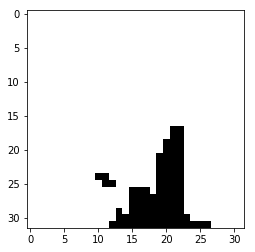

In [12]:
filenames = os.listdir(PATH+'resized/')

test_images = np.array([sk.io.imread(PATH+'resized/' + filenames[i]) for i in range(2)])

test_images = np.array([sk.transform.resize(image, IMAGE_SIZE) for image in test_images])

masks_o, landmarks = model.predict(test_images)
masks = (masks_o > 0.8).astype(np.uint8)

print(masks[0].shape)
for i in range(2):
    mask = np.squeeze(masks[i]).astype(np.float32)
    plt.imshow(np.dstack((mask,mask,mask)))
    
plt.show()